## Init

In [1]:
import random 
from scipy import stats
import statistics
import timeit
import scipy.stats
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import time
from IPython import display
from multiprocessing import Pool

plt.rcParams['figure.figsize'] = [24, 16]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


%matplotlib inline

## Zadanie 1

## Zadanie 2

In [2]:
class PBILRunner():
    def __init__(self, initial_probs, population_size, fitness_funct, entity_renderer, learning_rate, pool_size = 0):
        self.fitness_funct = fitness_funct
        self.genome = initial_probs
        self.popsize = population_size
        self.entity_renderer = entity_renderer
        self.learning_rate = learning_rate
        self.population = []
        self.mut_prob = 0.001
        self.mut_rate = 0.2
        self.pool = pool_size
        pass
    
    def debug(self):
        print(self.fitness_funct)
        print(self.entity_renderer)
        
    
    def set_genome(self, newgenome):
        self.genome = newgenome
        self.population = []
    
    def generate_children(self, verbose = False):
        if verbose:
            print(f"clearing the genepool")
            print(f"generating {self.popsize} children, each {len(self.genome)} genes long")
        self.population = []
        for _ in range(self.popsize):
            entity = [True if random.random() < i else False for i in self.genome]
            self.population.append(entity)
            
    def render_entities(self, verbose = False):
        return [self.entity_renderer(i) for i in self.population]
    
    def calculate_fitness(self, rendered, verbose = False):
        return [self.fitness_funct(answ) for answ in rendered]
    
    def bake(self, e):
        rendered = self.entity_renderer(e)
        fitted = self.fitness_funct(rendered)
        return fitted
    
    def efficient_render_pipeline(self, verbose = False):
        if self.pool == 0:
            return [self.bake(e)for e in self.population]
        else:
            with Pool(self.pool) as p:
                return p.map(self.bake, self.population)
    
    def peak_entity_finder(self, fitnesses, verbose = False):
        ranking = np.argsort(fitnesses)
        if verbose:
            print(f"peak performer {self.population[ranking[-1]]} with score {fitnesses[ranking[-1]]} in {fitnesses}")
        return (fitnesses[ranking[-1]], self.population[ranking[-1]])
    
    def modify_genome(self, target):
        for genit, gene in enumerate(target):
            if random.random() < self.mut_prob:
                if random.random() > 0.5:
                    self.genome[genit] = self.genome[genit]*(1.0 - self.mut_rate) + self.mut_rate
                else:
                    self.genome[genit] = self.genome[genit]*(1.0 - self.mut_rate)
            else:
                if gene:
                    self.genome[genit] = self.genome[genit]*(1.0 - self.learning_rate) + self.learning_rate
                else:
                    self.genome[genit] = self.genome[genit]*(1.0 - self.learning_rate)
    
    def execute_pipeline(self, iterations, verbose = False, fitchart = None, bestchart = None, gene_chart = None, chart_handle = None, checkpoint = None):
        pipeline_results = []
        pipeline_mean = []
        pipeline_max = []
        gene_collector = []
        best = 0
        for pipit in range(iterations):
            self.generate_children()
            scores = self.efficient_render_pipeline()
            score, entity = self.peak_entity_finder(scores, False)
            if verbose:
                print(f"iteration {pipit} fitness {score}")
            pipeline_results.append(score)
            pipeline_mean.append(statistics.mean(scores))
            if score > best:
                best = score
                pipeline_max.append(best)
                if checkpoint:
                    checkpoint(entity, score)
                if bestchart:
                    bestchart.plot([i for i in range(len(pipeline_max))], pipeline_max, c='red')
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    time.sleep(0.01)    
            if fitchart:
                fitchart.plot([i for i in range(len(pipeline_results))], pipeline_results, c='green')
                fitchart.plot([i for i in range(len(pipeline_mean))], pipeline_mean, c='orange')
                display.display(plt.gcf())
                display.clear_output(wait=True)
                time.sleep(0.01)
                
            gene_collector.append(self.genome.copy())

            if gene_chart:
                for git, _ in enumerate(self.genome):
                    gene_chart.plot([i for i in range(len(gene_collector))], [g[git] for g in gene_collector])
                display.display(plt.gcf())
                display.clear_output(wait=True)
                time.sleep(0.01)
                
            self.modify_genome(entity)
        return pipeline_results
            
class PBILExperiment():
    def __init__(self):
        self.finished_experiments = 0
        self.todo_experiments = 0
        pass
    
    def execute_experiment(self, 
        population_sizes, 
        learning_rates, 
        probgen, # this defines problem size, could be more elegant, but it's good enough
        probgen_seeds,
        experiment_iterations,
        single_series_cap,
        fitness_funct,
        entity_renderer):
        total_experiments = len(population_sizes) * len(learning_rates) * len(probgen_seeds)
        results = {}
        print(f"you are about to run {total_experiments} different training scenarios")
        print(f"This means training {total_experiments * experiment_iterations} entities")
        print(f"Totalling {total_experiments * single_series_cap * experiment_iterations} pipeline runs")
        Problem_args = []
        for popsize in population_sizes:
            for learnrate in learning_rates:
                for prob_seed in probgen_seeds:
                    print(f"baking pipeline for popsize:{popsize}, learnrate:{learnrate}, problemsize:{prob_seed}")
                    PBIL_instance = PBILRunner(
                        initial_probs = None,
                        population_size = popsize,
                        fitness_funct = fitness_funct,
                        entity_renderer = entity_renderer,
                        learning_rate = learnrate
                    )
                    
                    Problem_args.append((experiment_iterations, single_series_cap, PBIL_instance, probgen, prob_seed))

        print("prepared PIBL instances")
        self.todo_experiments = len(Problem_args)
        
        for p in Problem_args:
            print(p)
        with Pool(8) as p:
            results = p.map(self.execute_parametrized_series, Problem_args)

        resdict = {}
        for res_desc, res_stuff in results:
            resdict[f"{res_desc[2]}#{res_desc[1]}#{res_desc[0]}"] = res_stuff
        
        return resdict
    
    def execute_parametrized_series(self, problem_args):
        experiment_iterations, pipeline_iterations, PBILmodel, probgen, probseed = problem_args
        mins, maxs, avgs = [], [], []
        results = []
        for _ in tqdm(range(experiment_iterations)):
            PBILmodel.set_genome(probgen(probseed))
            results.append(PBILmodel.execute_pipeline(pipeline_iterations))
            
        for timeit in range(len(results[0])):
            mins.append(min(res[timeit] for res in results))
            maxs.append(max(res[timeit] for res in results))
            avgs.append(statistics.mean(res[timeit] for res in results))
        
        return ((probseed, PBILmodel.learning_rate, PBILmodel.popsize), (mins, maxs, avgs))

### One Max

In [ ]:
def onemax_fitness(genome):
    return sum(genome)

def onemax_renderer(genome):
    return [1 if i else 0 for i in genome]

def onemax_generator(genlen):
    return [random.random() for _ in range(genlen)]

problem_sizes = [16, 64, 256, 1024]
population_sizes = [8, 16, 64, 256]
learning_rates = [0.01, 0.05, 0.1, 0.2]
experiment_length = 750

experiment_obj = PBILExperiment()

experiment_data = experiment_obj.execute_experiment(
    population_sizes = population_sizes,
    learning_rates = learning_rates,
    probgen = onemax_generator,
    probgen_seeds = problem_sizes,
    experiment_iterations = 30, 
    single_series_cap = experiment_length,
    fitness_funct = onemax_fitness,
    entity_renderer = onemax_renderer,
)

eframe = [i for i in range(experiment_length)]

you are about to run 64 different training scenarios
This means training 1920 entities
Totalling 1440000 pipeline runs
baking pipeline for popsize:8, learnrate:0.01, problemsize:16
baking pipeline for popsize:8, learnrate:0.01, problemsize:64
baking pipeline for popsize:8, learnrate:0.01, problemsize:256
baking pipeline for popsize:8, learnrate:0.01, problemsize:1024
baking pipeline for popsize:8, learnrate:0.05, problemsize:16
baking pipeline for popsize:8, learnrate:0.05, problemsize:64
baking pipeline for popsize:8, learnrate:0.05, problemsize:256
baking pipeline for popsize:8, learnrate:0.05, problemsize:1024
baking pipeline for popsize:8, learnrate:0.1, problemsize:16
baking pipeline for popsize:8, learnrate:0.1, problemsize:64
baking pipeline for popsize:8, learnrate:0.1, problemsize:256
baking pipeline for popsize:8, learnrate:0.1, problemsize:1024
baking pipeline for popsize:8, learnrate:0.2, problemsize:16
baking pipeline for popsize:8, learnrate:0.2, problemsize:64
baking pip

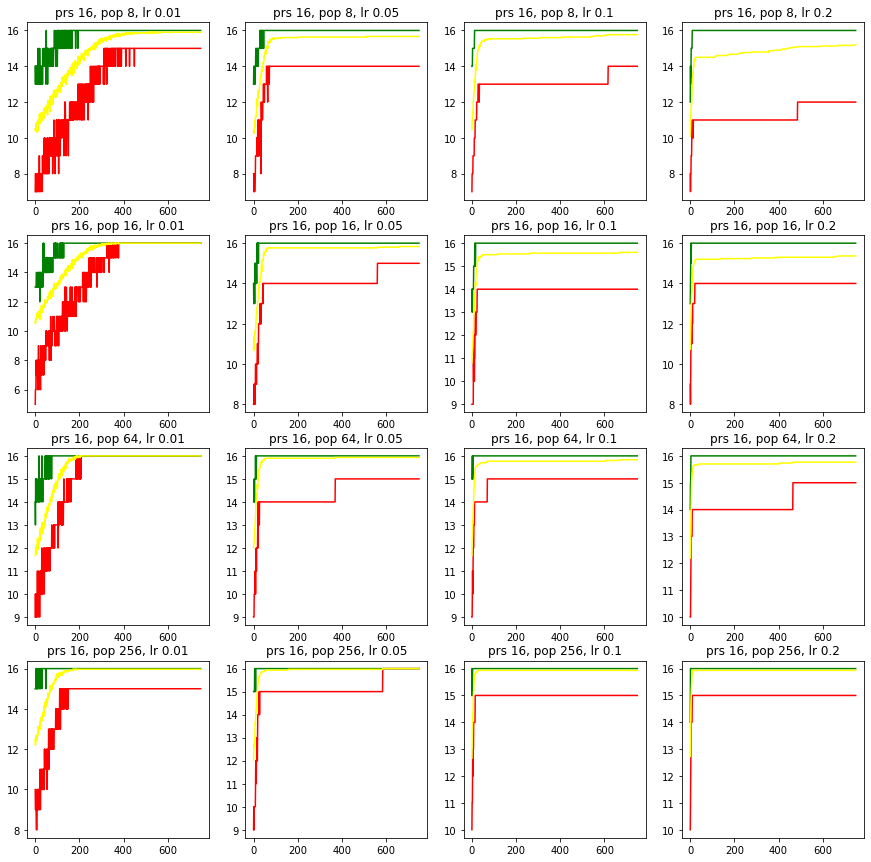

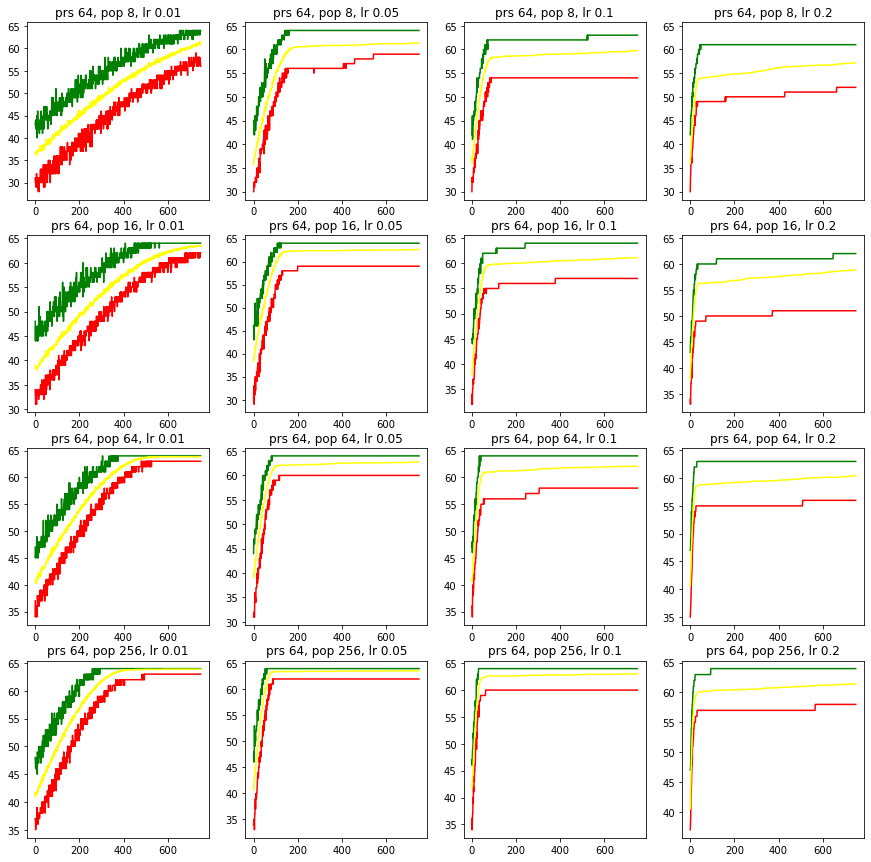

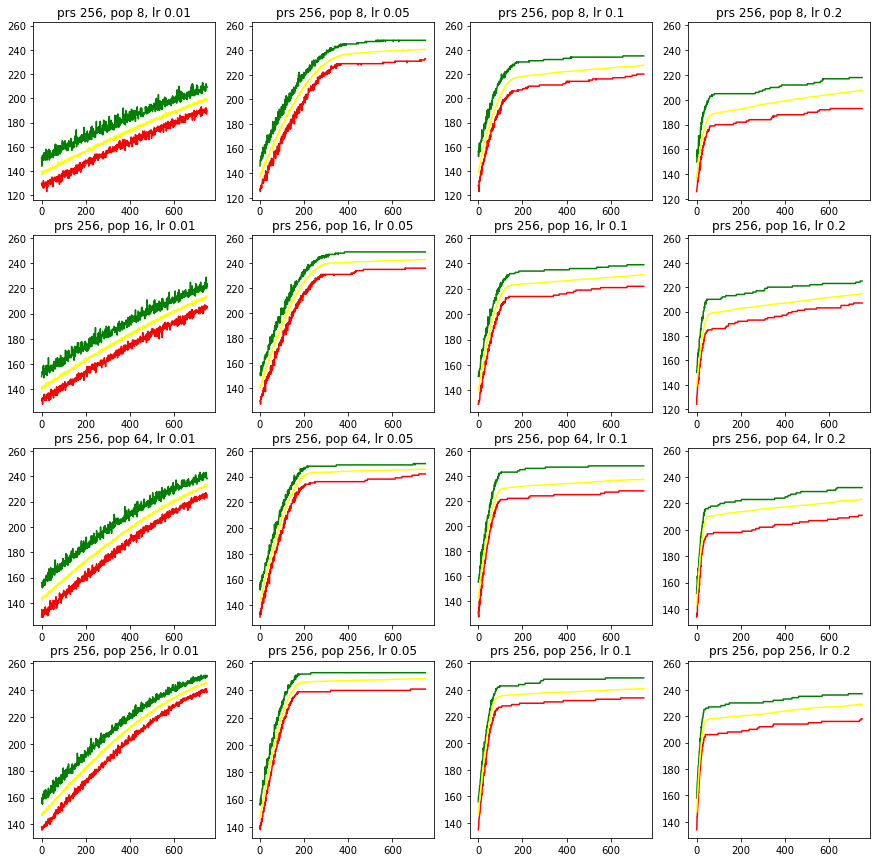

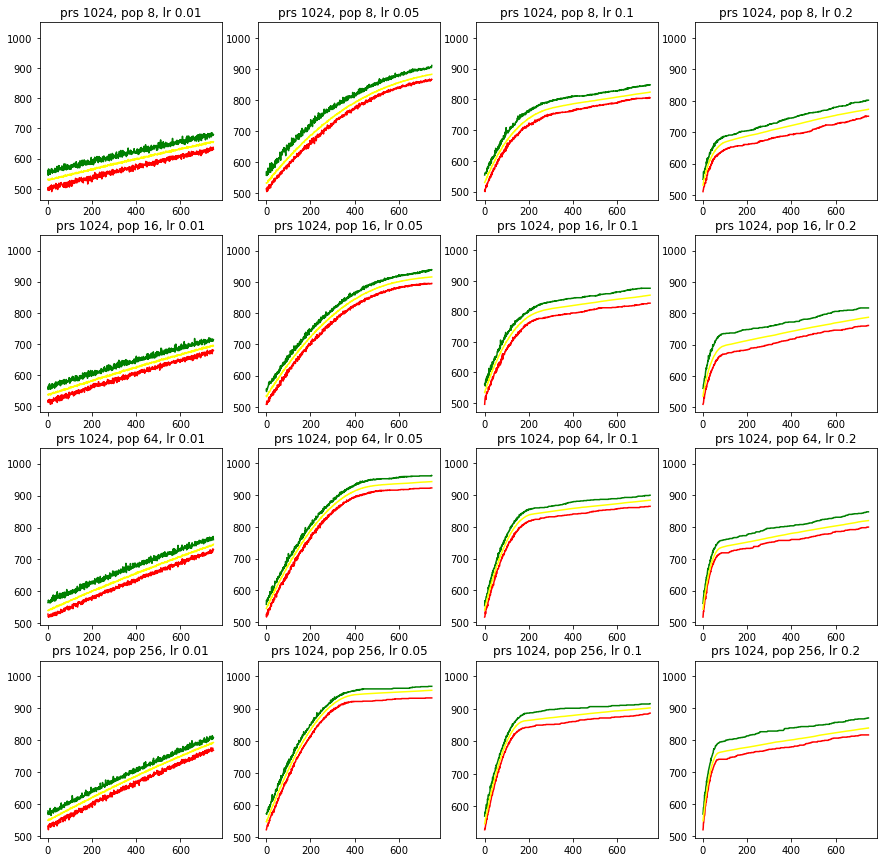

In [12]:
for prs in problem_sizes:
    fig, axs = plt.subplots(len(population_sizes), len(learning_rates), figsize = (15, 15))
    for psit, ps in enumerate(population_sizes):
        for lrit, lr in enumerate(learning_rates):
            axs[psit,lrit].set_title(f"prs {prs}, pop {ps}, lr {lr}")
            axs[psit,lrit].plot(eframe, [prs for _ in range(experiment_length)], c='white')
            axs[psit,lrit].plot(eframe, experiment_data[f"{ps}#{lr}#{prs}"][0], c='red')
            axs[psit,lrit].plot(eframe, experiment_data[f"{ps}#{lr}#{prs}"][1], c='green')
            axs[psit,lrit].plot(eframe, experiment_data[f"{ps}#{lr}#{prs}"][2], c='yellow')

## Deceptive One-Max

In [13]:
def deceptive_onemax_fitness(genome):
    if sum(genome) > 0:
        return sum(genome)
    else:
        return len(genome) + 1

def deceptive_onemax_renderer(genome):
    return [1 if i else 0 for i in genome]

def deceptive_onemax_generator(genlen):
    return [random.random() for _ in range(genlen)]

dom_problem_sizes = [8, 16, 32, 64]
dom_population_sizes = [8, 16, 64, 256]
dom_learning_rates = [0.01, 0.05, 0.1, 0.2]
dom_experiment_length = 750

deceptive_onemax_experiment_obj = PBILExperiment()

deceptive_onemax_experiment_data = deceptive_onemax_experiment_obj.execute_experiment(
    population_sizes = dom_population_sizes,
    learning_rates = dom_learning_rates,
    probgen = deceptive_onemax_generator,
    probgen_seeds = dom_problem_sizes,
    experiment_iterations = 30, 
    single_series_cap = dom_experiment_length,
    fitness_funct = deceptive_onemax_fitness,
    entity_renderer = deceptive_onemax_renderer,
)

eframee = [i for i in range(dom_experiment_length)]

you are about to run 64 different training scenarios
This means training 1920 entities
Totalling 1440000 pipeline runs
baking pipeline for popsize:8, learnrate:0.01, problemsize:8
baking pipeline for popsize:8, learnrate:0.01, problemsize:16
baking pipeline for popsize:8, learnrate:0.01, problemsize:32
baking pipeline for popsize:8, learnrate:0.01, problemsize:64
baking pipeline for popsize:8, learnrate:0.05, problemsize:8
baking pipeline for popsize:8, learnrate:0.05, problemsize:16
baking pipeline for popsize:8, learnrate:0.05, problemsize:32
baking pipeline for popsize:8, learnrate:0.05, problemsize:64
baking pipeline for popsize:8, learnrate:0.1, problemsize:8
baking pipeline for popsize:8, learnrate:0.1, problemsize:16
baking pipeline for popsize:8, learnrate:0.1, problemsize:32
baking pipeline for popsize:8, learnrate:0.1, problemsize:64
baking pipeline for popsize:8, learnrate:0.2, problemsize:8
baking pipeline for popsize:8, learnrate:0.2, problemsize:16
baking pipeline for pop

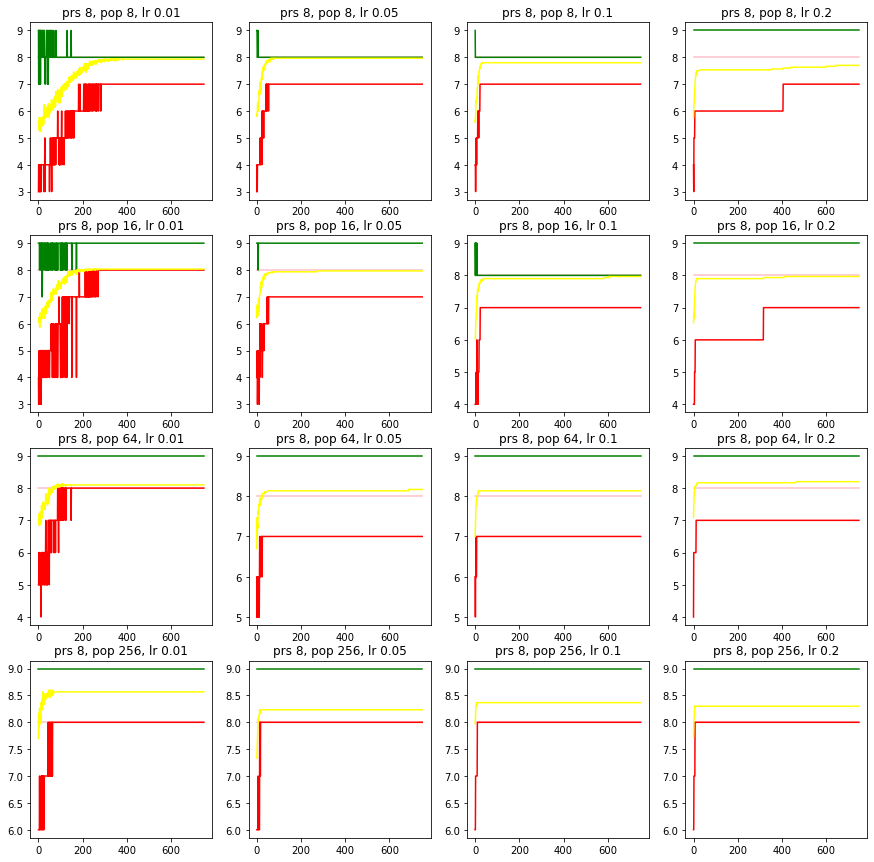

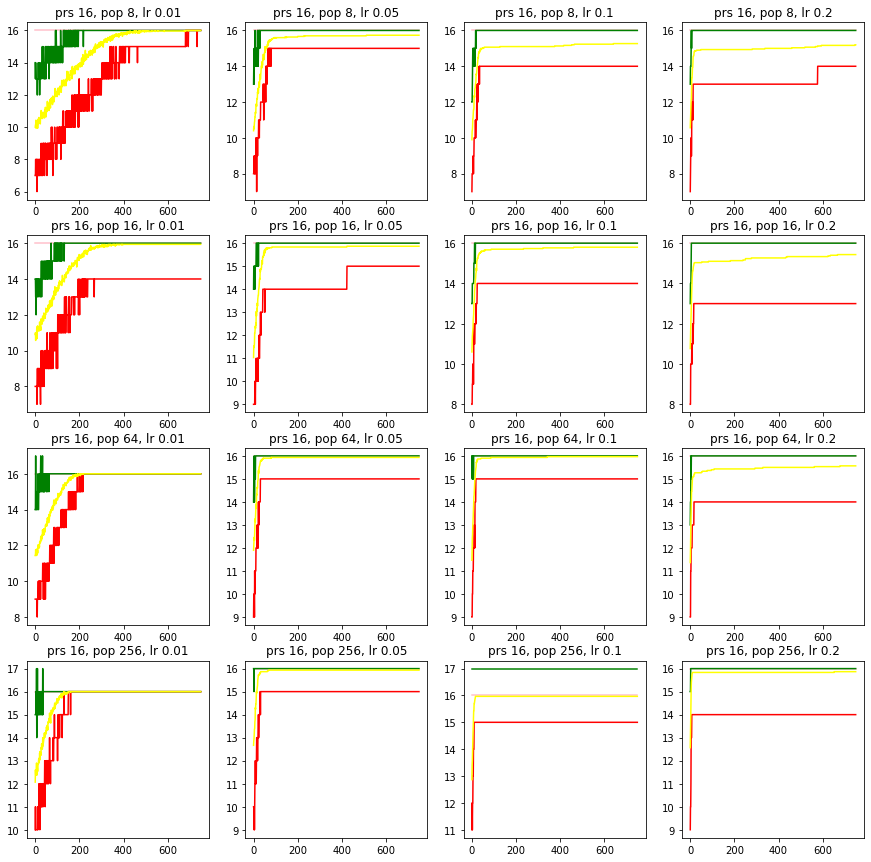

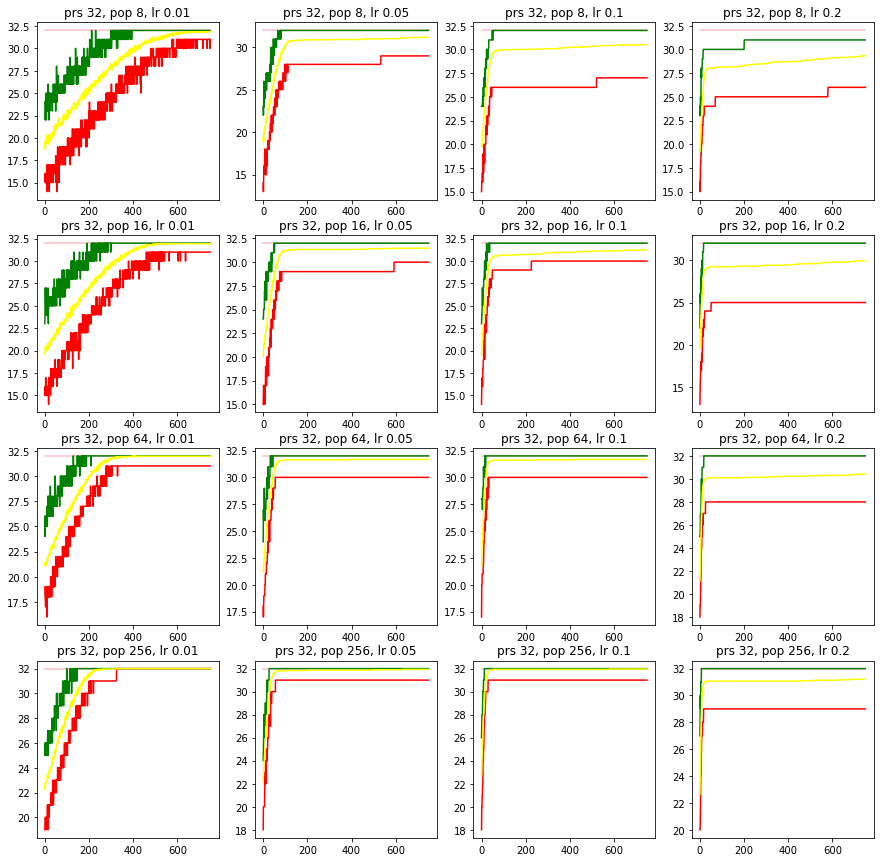

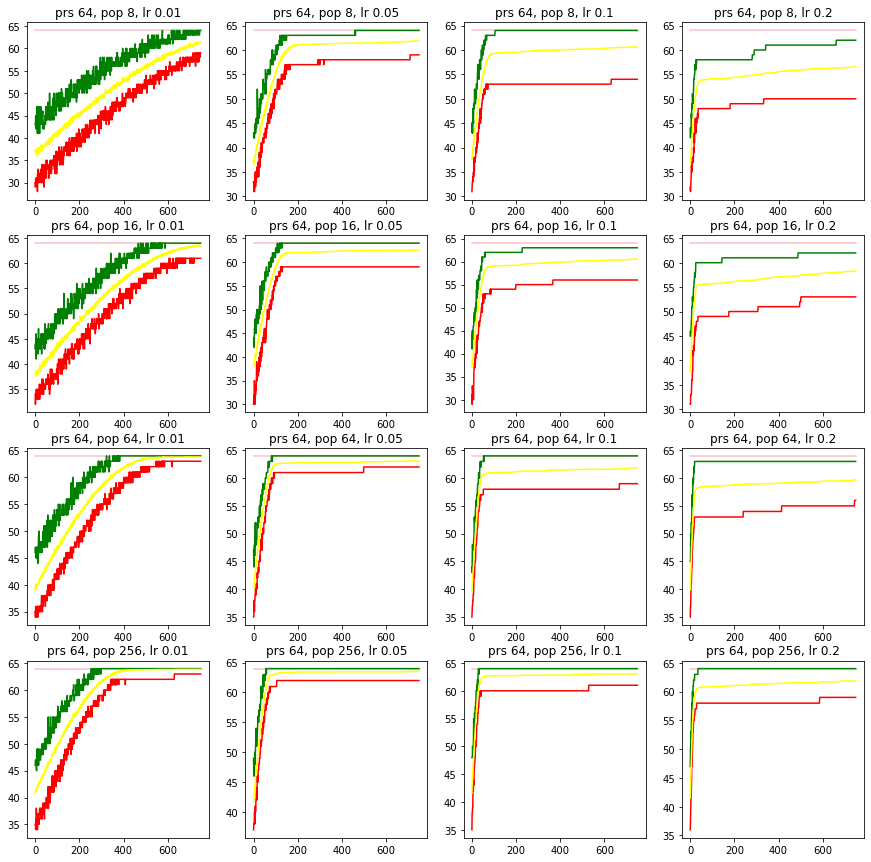

In [14]:
for prs in dom_problem_sizes:
    fig, axs = plt.subplots(len(dom_population_sizes), len(dom_learning_rates), figsize = (15, 15))
    for psit, ps in enumerate(dom_population_sizes):
        for lrit, lr in enumerate(dom_learning_rates):
            axs[psit,lrit].set_title(f"prs {prs}, pop {ps}, lr {lr}")
            axs[psit,lrit].plot(eframee, [prs for _ in range(dom_experiment_length)], c='pink')
            axs[psit,lrit].plot(eframee, deceptive_onemax_experiment_data[f"{ps}#{lr}#{prs}"][0], c='red')
            axs[psit,lrit].plot(eframee, deceptive_onemax_experiment_data[f"{ps}#{lr}#{prs}"][1], c='green')
            axs[psit,lrit].plot(eframee, deceptive_onemax_experiment_data[f"{ps}#{lr}#{prs}"][2], c='yellow')

### K-deceptive one max

In [15]:
def kdeceptive_onemax_fitness(genome):
    l = len(genome)
    return deceptive_onemax_fitness(genome[0:l//2]) + deceptive_onemax_fitness(genome[l//2:])

def kdeceptive_onemax_renderer(genome):
    return [1 if i else 0 for i in genome]

def kdeceptive_onemax_generator(genlen):
    return [random.random() for _ in range(genlen)]

kdom_problem_sizes = [8, 16, 32, 64]
kdom_population_sizes = [8, 16, 64, 256]
kdom_learning_rates = [0.01, 0.05, 0.1, 0.2]
kdom_experiment_length = 750

kdeceptive_onemax_experiment_obj = PBILExperiment()

kdeceptive_onemax_experiment_data = kdeceptive_onemax_experiment_obj.execute_experiment(
    population_sizes = kdom_population_sizes,
    learning_rates = kdom_learning_rates,
    probgen = kdeceptive_onemax_generator,
    probgen_seeds = kdom_problem_sizes,
    experiment_iterations = 30, 
    single_series_cap = kdom_experiment_length,
    fitness_funct = kdeceptive_onemax_fitness,
    entity_renderer = kdeceptive_onemax_renderer,
)

you are about to run 64 different training scenarios
This means training 1920 entities
Totalling 1440000 pipeline runs
baking pipeline for popsize:8, learnrate:0.01, problemsize:8
baking pipeline for popsize:8, learnrate:0.01, problemsize:16
baking pipeline for popsize:8, learnrate:0.01, problemsize:32
baking pipeline for popsize:8, learnrate:0.01, problemsize:64
baking pipeline for popsize:8, learnrate:0.05, problemsize:8
baking pipeline for popsize:8, learnrate:0.05, problemsize:16
baking pipeline for popsize:8, learnrate:0.05, problemsize:32
baking pipeline for popsize:8, learnrate:0.05, problemsize:64
baking pipeline for popsize:8, learnrate:0.1, problemsize:8
baking pipeline for popsize:8, learnrate:0.1, problemsize:16
baking pipeline for popsize:8, learnrate:0.1, problemsize:32
baking pipeline for popsize:8, learnrate:0.1, problemsize:64
baking pipeline for popsize:8, learnrate:0.2, problemsize:8
baking pipeline for popsize:8, learnrate:0.2, problemsize:16
baking pipeline for pop

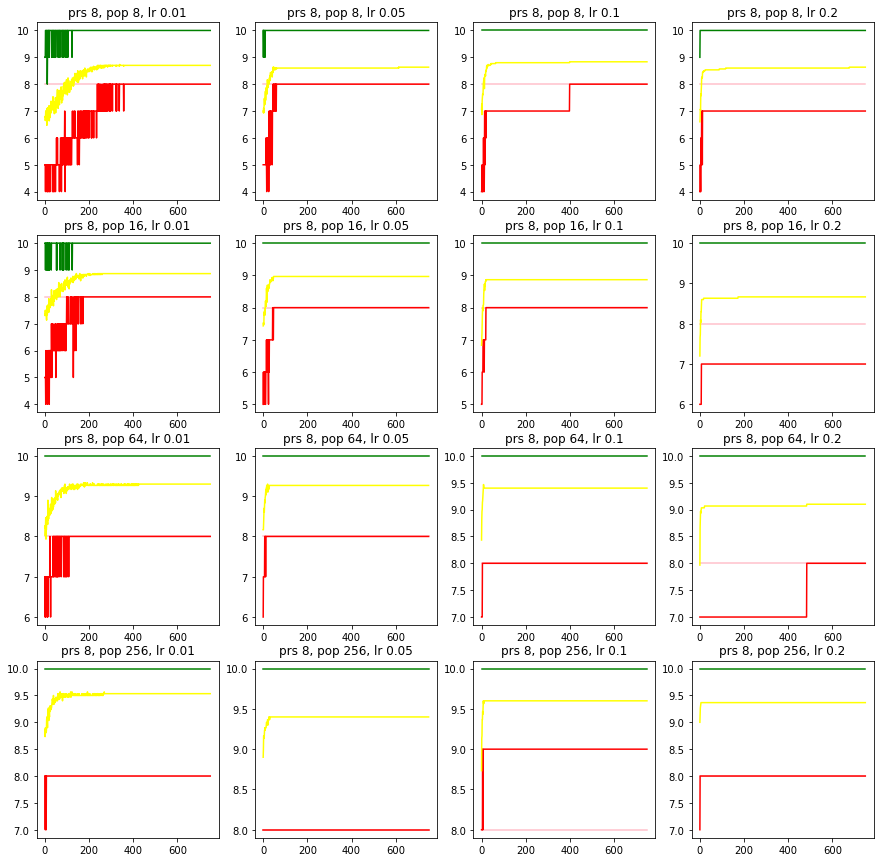

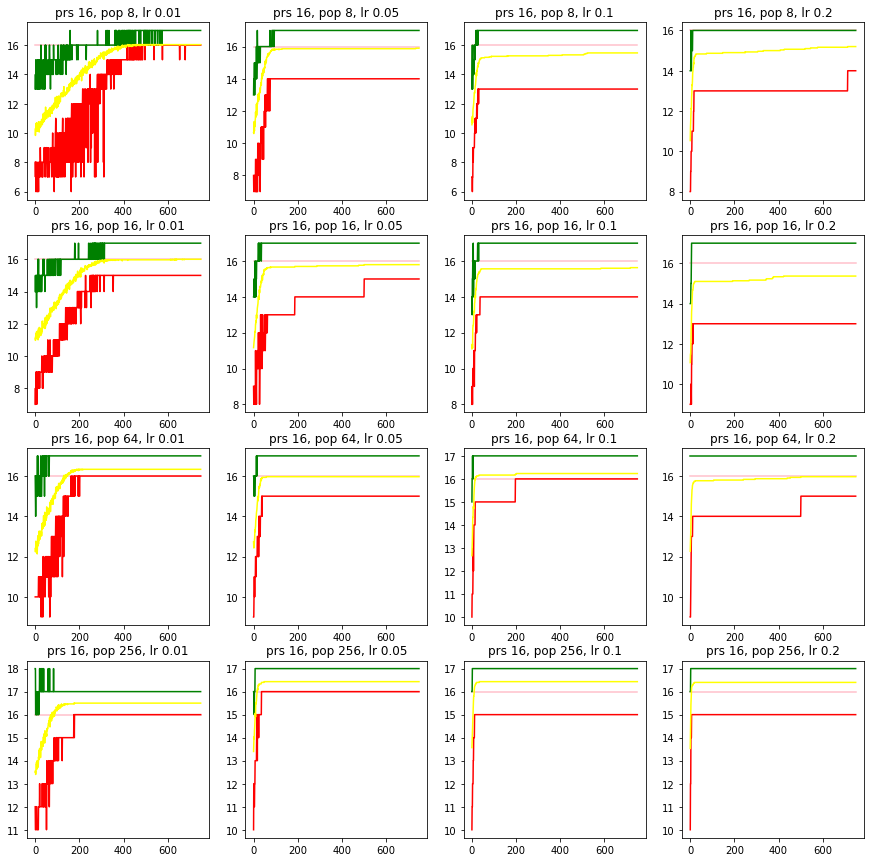

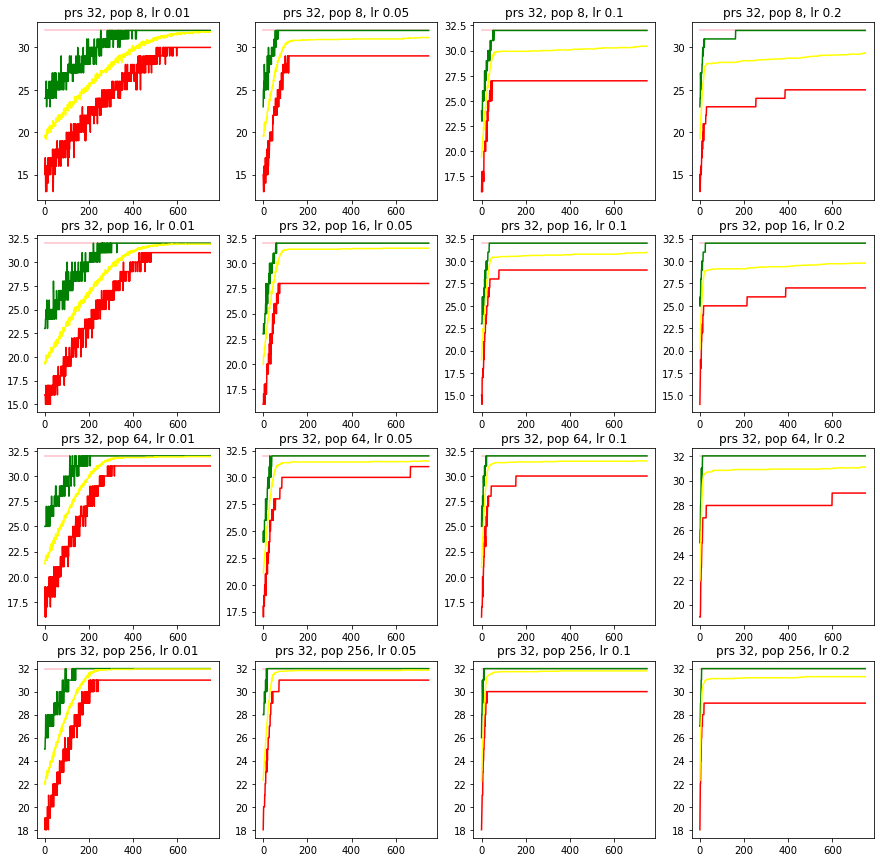

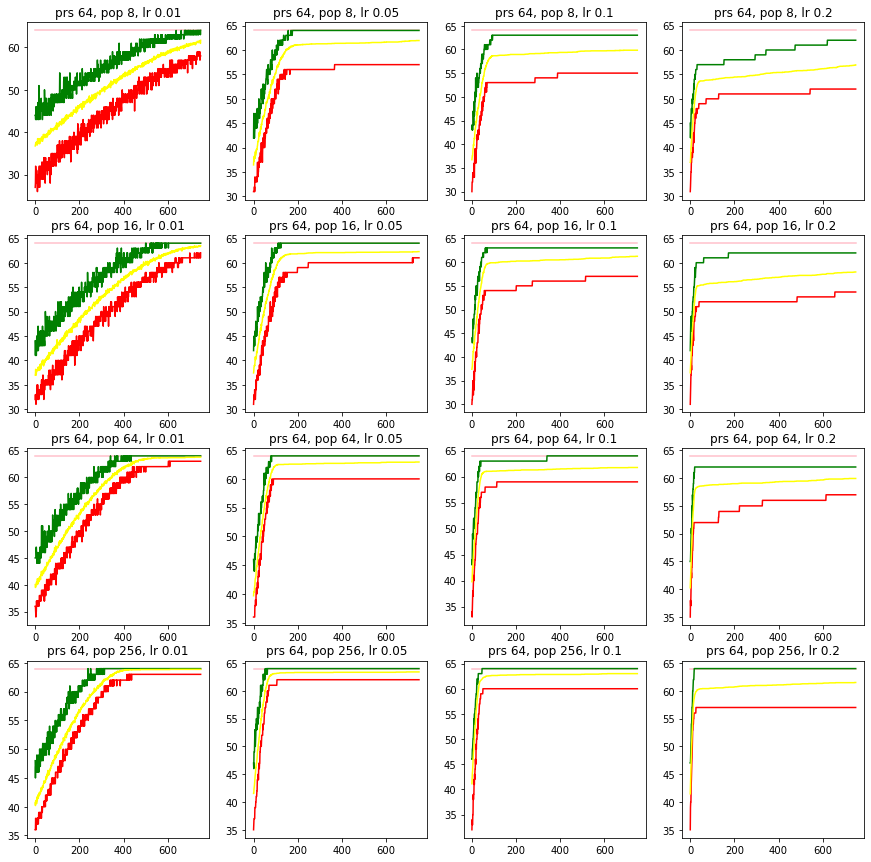

In [16]:
keframe = [i for i in range(kdom_experiment_length)]
for prs in kdom_problem_sizes:
    fig, axs = plt.subplots(len(kdom_population_sizes), len(kdom_learning_rates), figsize = (15, 15))
    for psit, ps in enumerate(kdom_population_sizes):
        for lrit, lr in enumerate(kdom_learning_rates):
            axs[psit,lrit].set_title(f"prs {prs}, pop {ps}, lr {lr}")
            axs[psit,lrit].plot(keframe, [prs for _ in range(kdom_experiment_length)], c='pink')
            axs[psit,lrit].plot(keframe, kdeceptive_onemax_experiment_data[f"{ps}#{lr}#{prs}"][0], c='red')
            axs[psit,lrit].plot(keframe, kdeceptive_onemax_experiment_data[f"{ps}#{lr}#{prs}"][1], c='green')
            axs[psit,lrit].plot(keframe, kdeceptive_onemax_experiment_data[f"{ps}#{lr}#{prs}"][2], c='yellow')

## Zadanie 3

In [3]:
image_shape = (106, 148)

# data from the satellite, only classes 3, 7, 9
def sanitize_class(class_):
    cl = [float(c) for c in class_.split(" ") if len(c) > 1]
    return cl
    
def SuccRawImageData():
    data = []
    with open("ImageRawReduced.txt", "r") as f:
        c1, c2, c3, _ = f.read().split("\n")
        c1 = sanitize_class(c1)
        c2 = sanitize_class(c2)
        c3 = sanitize_class(c3)
        return [c1, c2, c3]

# desired classification data, classes 1, 2, 3
def SuccExpertImageData():
    data = []
    with open("ImageExpertReduced.txt", "r") as f:
        c1 = (f.read().split("\n"))[0]
        return sanitize_class(c1)
    
def SuccClasificationRules():
    ruleset = []
    with open("ClassificationRules.txt", "r") as f:
        for rule in f.read().split("\n"):
            if len(rule) > 10:
                ruleset.append(sanitize_class(rule))
    return ruleset
    
raw_data = SuccRawImageData()
desired_data = SuccExpertImageData()
classification_rules = SuccClasificationRules()
print(f"loaded {len(classification_rules)} classification rules")
print(f"rule 0 is {len(classification_rules[0])} dimentions long")

def softsort(b):
    if b[0] >= b[1] and b[0] >= b[2]:
        return 1
    elif b[1] >= b[0] and b[1] >= b[2]:
        return 2
    elif b[2] >= b[1] and b[2] >= b[0]:
        return 3    

def calculate_score(test_data, desired_data):
    assert len(test_data) == len(desired_data)
    correct = 0
    for it in range(len(test_data)):
        if test_data[it] == desired_data[it]:
            correct += 1
    return float(correct)/float(len(test_data))

def continuous_bucket_score(test_buckets, desired_data):
    score = 0.0
    for it in range(len(test_buckets)):        
        if softsort(test_buckets[it]) == desired_data[it]:
            score += 10.0
        else:
            mx = float(max(test_buckets[it][oi] for oi in range(3)))
            score += test_buckets[it][int(desired_data[it]) - 1]/mx * 2.0
            score -= test_buckets[it][0]/mx
            score -= test_buckets[it][1]/mx
            score -= test_buckets[it][2]/mx
    return score
            
for i in range(10):
    print(calculate_score(classification_rules[i], desired_data))

loaded 266 classification rules
rule 0 is 9350 dimentions long
0.6453475935828877
0.7038502673796792
0.4702673796791444
0.4760427807486631
0.4709090909090909
0.4918716577540107
0.533903743315508
0.47689839572192516
0.5820320855614973
0.6253475935828877


In [4]:
def bake(specimen, method = 'cont', verbose = False):
    buckets = np.zeros((len(classification_rules[1]), 3))

    if verbose:
        print(f"initializing bucket with {len(classification_rules[1])}x{3}")
    
    # ruleit to reguła, gene to jej waga
    for ruleit, gene in enumerate(specimen):
        for tid, target in enumerate(classification_rules[ruleit]):
            buckets[int(tid)][int(target) - 1] += gene

    baked = []
    
    for b in buckets:
        baked.append(softsort(b))
    
    if verbose:
        print(len(baked), len(buckets), len(desired_data))
    
    if method == 'disc':
        return calculate_score(baked, desired_data)
    
    if method == 'cont':
        return continuous_bucket_score(buckets, desired_data)

def render(specimen):
    buckets = np.zeros((len(classification_rules[1]), 3))

    for ruleit, gene in enumerate(specimen):
        for tid, target in enumerate(classification_rules[ruleit]):
            buckets[int(tid)][int(target) - 1] += gene

    baked = []
    
    for b in buckets:
        baked.append(softsort(b))
    return baked
    
    
fail = False
for i in range(10):
    genome = [0.0 for j in classification_rules]
    genome[i] = 1.0
    scorea = bake(genome, 'disc')
    scoreb = calculate_score(classification_rules[i], desired_data)
    if scorea != scoreb:
        fail = True
        print(f"bake returned {scorea}, expected {scoreb}")
        
if fail:
    print("bake tests failed")
else:
    print("bake tests passed")

bake tests passed


In [5]:
genome = [0.5 for i in classification_rules]
learning_rate = 0.1
mut_prob = 0.01
mut_shift = 0.02

def dump_file(genome, fitness):
    with open(f"pure_gene_{fitness}_.txt", "w") as f:
        for g in genome:
            f.write(f"{g}\n")
            
record = 1.0
best, mean, stdev = [], [], []
iteration = []
static_score = []
geneh = [[] for i in range(20)]

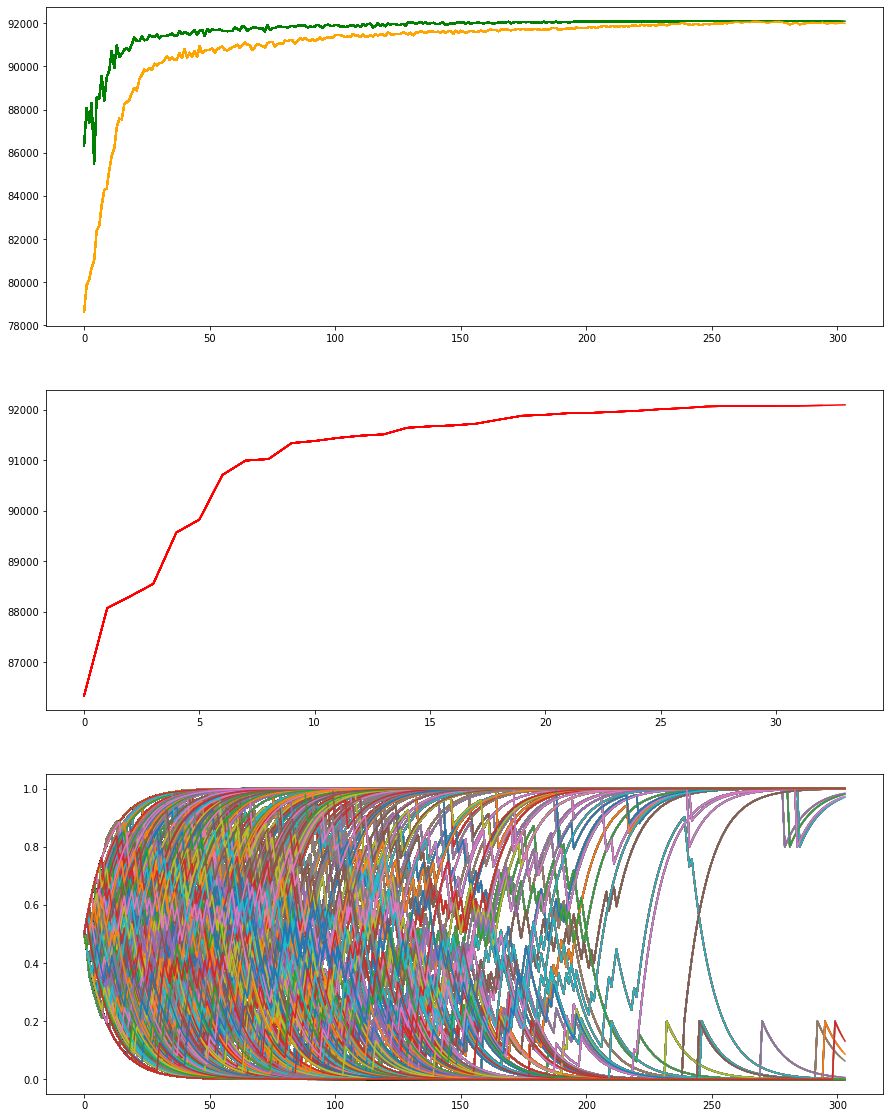

In [ ]:
def map_renderer(genome):
    return [1.0 if g else 0.0 for g in genome]

def map_fitness(genome):
    return bake(genome, 'cont')
    
map_pbil = PBILRunner(
    initial_probs = [0.5 for i in classification_rules],
    population_size = 64,
    fitness_funct = map_fitness,
    entity_renderer = map_renderer,
    learning_rate = 0.1,
    pool_size = 8,
)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, constrained_layout=False, figsize = (15, 20))
pipeline_results = map_pbil.execute_pipeline(512, False, fitchart = ax1, bestchart = ax2, gene_chart = ax3, chart_handle = fig, checkpoint=dump_file)


In [ ]:
population_size = 4
fig, ax = plt.subplots()
fig, (td, ax0, ax1, ax2) = plt.subplots(nrows=4, constrained_layout=False, figsize = (15, 20))

yd = int(9350/(11*17))
xd = 11*17

fyp = []
fxp = []
for i in range(yd):
    for j in range(xd):
        fyp.append(i)
        fxp.append(j)
        
td.scatter(fyp, fxp, c = [int(c) for c in desired_data])

for i in range(4):
    #print("------")
    iteration.append(i)
    # create population
    population = []
    for _ in range(population_size):
        population.append([
            learning_rate - random.random() * 2.0 * learning_rate + genome[i] for i in range(len(classification_rules))
        ])
    
    # evauate population
    scores = []
    
    #scores = [bake(s) for s in population]
    with Pool(8) as p:
        scores = p.map(bake, population)
    
    #print(max(scores)) 
    #print(genome[:10])
    leaderboard = np.argsort(scores)

    best.append(max(scores))
    # draw graphs
    td.scatter(fyp, [x-250 for x in fxp], c = [int(c) for c in render(population[leaderboard[-1]])])

    static_score.append(bake(population[leaderboard[-1]], "disc"))
    
    for i in range(20):
        geneh[i].append(genome[10*i])
    
    #print(iteration, best)
    ax0.plot(iteration, best, color='red')
    for i in range(20):
        ax1.plot(iteration, geneh[i])
        
    ax2.plot(iteration, static_score, color='red')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.01)
 
    # pick winner

    if record < scores[leaderboard[-1]]:
        #print(f"new record!!! {record} -> {scores[leaderboard[0]]}")
        record = scores[leaderboard[-1]]
        dump_file(genome, record)
    
    # generate kids
    for vdim in range(len(classification_rules)):
        if random.random() < mut_prob:
            if random.random() > 0.5:
                genome[vdim] = (1.0 - mut_shift) * genome[vdim] + mut_shift
            else:
                genome[vdim] = (1.0 - mut_shift) * genome[vdim] - mut_shift
        else:
            genome[vdim] = (1.0 - learning_rate) * genome[vdim] + learning_rate * population[leaderboard[-1]][vdim]

        genome[vdim] = max(min(1.0, genome[vdim]), 0.0)


In [ ]:
def load_genome(f):
    s = []
    with open(f, "r") as file:
        for l in file.read().split("\n"):
            if len(l) > 1:
                s.append(float(l))
    return s
            
peak_performance = load_genome("genedump_91156.7841981057_.txt")

# plik zawiera środki rozkładów, ale przyjmujemy +/-0 bo w sumie taki osobnik też byłby generowany
fig, (ax0, ax1) = plt.subplots(nrows=2, constrained_layout=False, figsize = (15, 10))

yd = int(9350/(11*17))
xd = 11*17

fyp = []
fxp = []
for i in range(yd):
    for j in range(xd):
        fyp.append(i)
        fxp.append(j)

score = bake(peak_performance, "disc")
print(f"the peak performer has the score of {score}")
ax0.scatter(fyp, fxp, c = [int(c) for c in desired_data])
ax1.scatter(fyp, fxp, c = [int(c) for c in render(peak_performance)])


Tutaj screenshot z trenowania tego peak performera

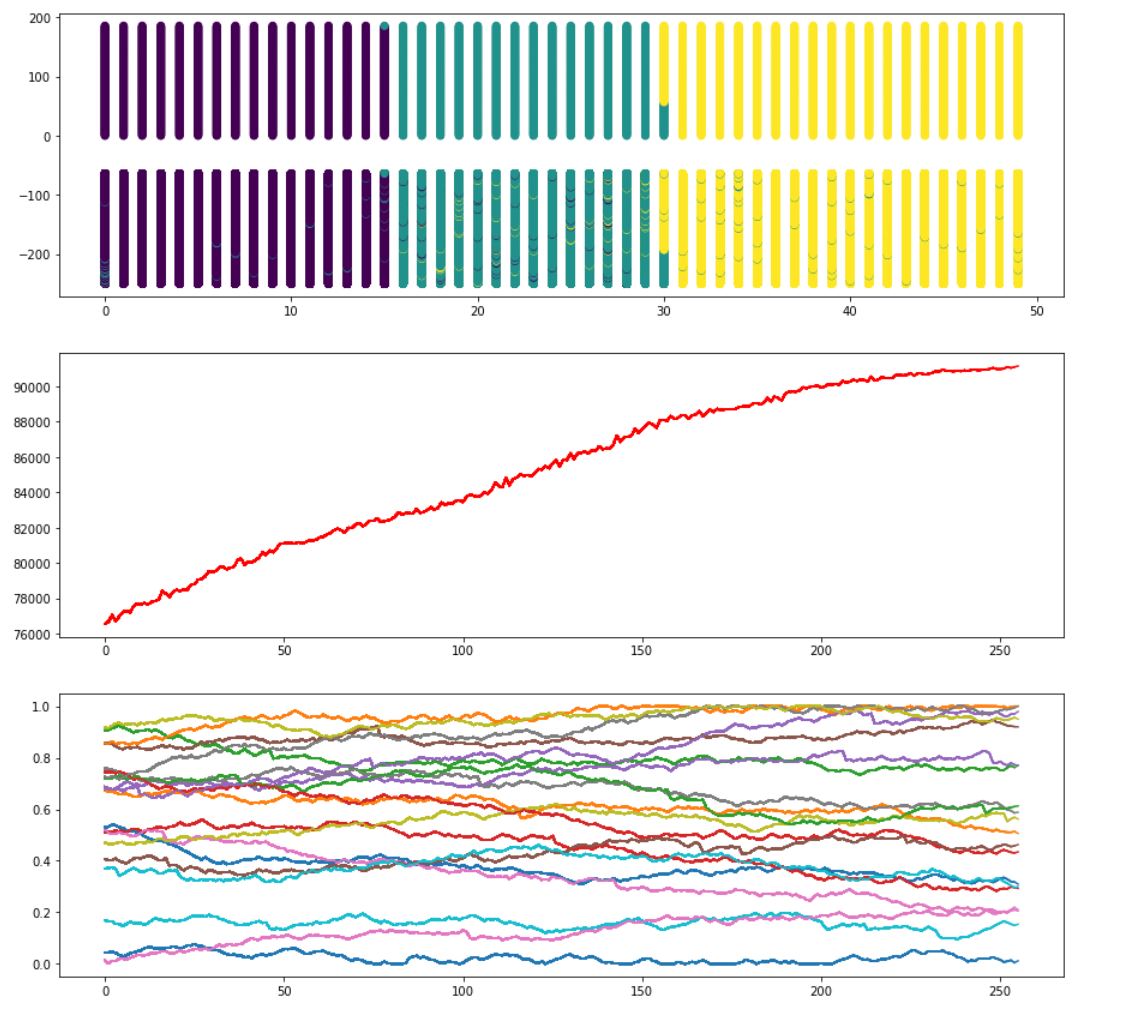